#### From the IBL database, get data on weight and trial counts under different water regimes at CSHL
Anne Urai, CSHL, 2019

In [1]:
# PYTHON STARTS BY IMPORTING 'MODULES' AND 'PACKAGES' THAT WE'LL USE LATER

# GENERAL THINGS FOR COMPUTING AND PLOTTING
import pandas as pd
import numpy as np
import os, sys, time

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", context="talk")

# set a path where you want figures to be saved
figpath  = os.path.join(os.path.expanduser('~'), 'Data/Figures_IBL')

# ibl specific things
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior
from ibl_pipeline.analyses import behavior as behavioral_analyses

# set path for saving figures
figpath  = os.path.join(os.path.expanduser('~'), 'Data/Figures_IBL')


Connecting anneurai@datajoint.internationalbrainlab.org:3306


If your login to DataJoint was successful, you should see something like 

'Connecting youruser@datajoint.internationalbrainlab.org:3306'

In [2]:
# FIND THE DATA WE NEED
# FIRST, WHICH SUBJECTS ARE DOING THIS CA EXPERIMENT?
subj = (subject.Subject() - subject.Death & 'subject_birth_date < "2018-09-01"').proj('subject_nickname', 'sex') * \
    (subject.SubjectLab() & 'lab_name="churchlandlab"').proj()
print(subj)

*subject_uuid  subject_nickna sex    
+------------+ +------------+ +-----+
1208c089-8b8e- IBL_13         M      
3e97e1d3-2a0f- IBL_34         M      
3f854f88-7879- IBL_11         M      
52a800fc-cbbc- IBL_1          M      
55381f61-4e47- IBL_46         M      
7c751b49-55a6- IBL_10         M      
 (Total: 6)



In [3]:
# get date for each weighing
weight_with_date = action.Weighing.proj('weight', session_date='DATE(weighing_time)')
# create a table with primary key to be the combination of subject_uuid and session_date
# dj.U, U means uniform, all possible combinations of subject uuid and session_date, when
# restricted with weight_with_date, it returns all existing combinations of subject_uuid and 
# session_date in the table weight_with_date
# Note that there are more entries in weight_with_date than in weight_date, indicating there
# exists more than one weighing for some dates.
weight_date = (dj.U('subject_uuid', 'session_date') & weight_with_date)

# Aggregation to get average weight for each date
# before .aggr is the table you want aggregate, basically you get one value for each entry in 
# weight_with_date
# first argument is the table that is useful to compute the value you need, here weight_with_date
# provides all weights for each date, 'weight' is an attribute in the table weight_with_date
# note that the results have the same number of entries as weight_date
avg_weight_date = weight_date.aggr(weight_with_date, avg_weight='AVG(weight)')

# NOW DO THE SAME FOR WATER
water_with_date = action.WaterAdministration.proj('watertype_name', 'water_administered', 'adlib',
                                                  session_date='DATE(administration_time)')
water_date = (dj.U('subject_uuid', 'session_date') & water_with_date)
# total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
#                                    watertype="CONCAT_WS('; ', watertype_name)")
total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
                                   watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
                                   adlib='MAX(adlib)')
# total_water_date = dj.U('subject_uuid', 'session_date').aggr(
#     water_with_date, 
#     total_water='SUM(water_administered)', 
#     watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
#     adlib='MAX(adlib)') & 'session_date > "2019-03-17"'

# get session with date
session_with_date = behavior.TrialSet.proj('n_trials') \
    * (acquisition.Session.proj(session_date='DATE(session_start_time)') & 'session_date > "2019-03-17"') \
    * behavioral_analyses.PsychResults()

# Now you can join (*) the two tables avg_weight_date and session_with_date.
# Join * will automatically find matched session_date in both tables, and only show entries where
# these dates exist in both tables. Note there are fewer entries in this resulting table, because
# on some dates weight is missing and other dates session is missing
b = subj * session_with_date * avg_weight_date * total_water_date

df = pd.DataFrame(b.fetch(as_dict=True))
df.tail(n=10)



# # TODO: updated code from Shan and Dimitri
# weight_with_date = action.Weighing.proj('weight', session_date='DATE(weighing_time)')
# water_with_date = action.WaterAdministration.proj('watertype_name', 'water_administered', 'adlib', 
#     session_date='DATE(administration_time)')
# total_water_date = dj.U('subject_uuid', 'session_date').aggr(
#     water_with_date, 
#     total_water='SUM(water_administered)', 
#     watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
#     adlib='MAX(adlib)') & 'session_date > "2019-05-01"'

# # get session with date
# session_with_date = behavior.TrialSet.proj(
#     'n_trials', session_date='DATE(session_start_time)') & 'session_date > "2019-05-01"'

# # Here you can get the all info including total water, adlib, average weight, and number of sessions per day
# water_session =  total_water_date.aggr(session_with_date, n_sessions="count(n_trials)", keep_all_rows=True) * total_water_date
# water_weight_session = water_session.aggr(weight_with_date, avg_weight='AVG(weight)', keep_all_rows=True) * water_session

,adlib,avg_weight,bias,lapse_high,lapse_low,n_trials,n_trials_stim,n_trials_stim_right,performance,performance_easy,prob_choose_right,session_date,session_start_time,sex,signed_contrasts,subject_nickname,subject_uuid,threshold,total_water,watertype
394,1,23.209999,0.014711,1.083580e-10,1.355700e-02,955,"[102, 119, 91, 112, 120, 118, 93, 98, 102]","[1, 11, 11, 31, 68, 85, 79, 89, 102]",0.843979,0.990196,"[0.00980392156862745, 0.09243697478991597, 0.1...",2019-06-14,2019-06-14 14:16:30,M,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....",IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,21.10540,2.4180,Water; Water 10% Sucrose
395,1,27.170000,23.029200,5.643690e-01,1.953870e-05,81,"[13, 10, 8, 9, 13, 6, 9, 6, 7]","[0, 0, 0, 0, 1, 1, 0, 2, 3]",0.382716,0.700000,"[0.0, 0.0, 0.0, 0.0, 0.07692307692307693, 0.16...",2019-06-18,2019-06-18 14:11:23,M,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....",IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,24.76120,0.0930,Water; Water 10% Sucrose
396,1,26.500000,8.565140,1.578350e-01,6.714810e-12,157,"[10, 11, 13, 16, 18, 35, 14, 24, 16]","[0, 0, 0, 1, 4, 9, 9, 20, 13]",0.630573,0.846154,"[0.0, 0.0, 0.0, 0.0625, 0.2222222222222222, 0....",2019-06-19,2019-06-19 13:52:50,M,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....",IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,13.15360,0.2970,Water; Water 10% Sucrose
397,1,26.870001,10.875400,2.699990e-01,3.169910e-12,99,"[13, 14, 12, 15, 9, 9, 10, 6, 11]","[0, 0, 3, 3, 2, 3, 2, 4, 8]",0.494949,0.708333,"[0.0, 0.0, 0.25, 0.2, 0.2222222222222222, 0.33...",2019-06-20,2019-06-20 13:43:10,M,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....",IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,35.40310,0.1470,Water; Water 10% Sucrose
398,1,26.440001,23.217600,4.199730e-10,1.529780e-02,85,"[7, 8, 13, 11, 8, 11, 6, 17, 4]","[0, 0, 0, 1, 0, 0, 0, 11, 4]",0.447059,0.818182,"[0.0, 0.0, 0.0, 0.09090909090909091, 0.0, 0.0,...",2019-06-21,2019-06-21 15:33:15,M,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....",IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,7.58382,0.1140,Water; Water 10% Sucrose
399,0,22.639999,0.238944,2.421310e-11,2.425390e-02,1112,"[128, 118, 130, 128, 112, 114, 128, 134, 120]","[2, 7, 14, 44, 53, 83, 112, 131, 120]",0.854317,0.991935,"[0.015625, 0.059322033898305086, 0.10769230769...",2019-06-24,2019-06-24 15:28:51,M,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....",IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,16.13190,2.8500,Water 10% Sucrose
400,0,22.389999,2.379600,2.349450e-02,8.808100e-03,1396,"[158, 163, 175, 148, 160, 142, 163, 136, 151]","[0, 2, 11, 18, 53, 96, 149, 129, 150]",0.884670,0.993528,"[0.0, 0.012269938650306749, 0.0628571428571428...",2019-06-25,2019-06-25 14:55:22,M,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....",IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,11.00740,3.7050,Water 10% Sucrose
401,0,22.610001,0.057162,1.678000e-02,4.840050e-02,1078,"[112, 112, 105, 130, 124, 117, 106, 127, 145]","[2, 9, 11, 37, 58, 91, 99, 124, 143]",0.856215,0.984436,"[0.017857142857142856, 0.08035714285714286, 0....",2019-06-26,2019-06-26 16:15:32,M,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....",IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,11.71890,2.7690,Water 10% Sucrose
402,0,24.020000,0.389151,4.817640e-02,2.642770e-02,769,"[110, 99, 78, 82, 87, 82, 80, 71, 80]","[4, 2, 5, 26, 40, 55, 71, 65, 78]",0.845254,0.968421,"[0.03636363636363636, 0.020202020202020204, 0....",2019-06-27,2019-06-27 14:20:48,M,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....",IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,13.12100,0.9750,Water 10% Sucrose
403,1,23.430000,2.186670,2.080720e-02,5.337090e-04,523,"[47, 48, 39, 59, 58, 65, 68, 64, 75]","[0, 3, 1, 21, 22, 45, 51, 55, 74]",0.812620,0.991803,"[0.0, 0.0625, 0.02564102564102564, 0.355932203...",2019-06-28,2019-06-28 13:55:01,M,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....",IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,22.27370,0.6375,Water 10% Sucrose; Water 2% Citric Acid


In [4]:
# ADD SOME MORE USEFUL INFO - group by week, from Saturday to Friday
df['session_date'] = pd.to_datetime(df.session_date)
df['week_number']  = df['session_date'].dt.week
df['weekday_name'] = df['session_date'].dt.day_name()
df['weekday']      = df['session_date'].dt.weekday

# THEN GIVE EVERY WEEK A CONDITION NAME!
#
# let's define 5 conditions
# O = one mL water in weekend, sucrose water in task
# C = citric acid water in weekend, sucrose water in task
# CC = citric acid water in weekend + week, sucrose water in task
# W = regular water in weekend, sucrose water in task
# WW = regular water in weekend + week, sucrose water in task
#
# now, we want to map these onto the week numbers
condition_map = {10:'CC', 11:'C', 12:'C', 13:'C', 14:'C', 15:'C', 16:'C', 
                 17:'CC', 18:'C', 19:'WW', 20:'O', 21:'C', 22:'C', 23:'C', 24:'C', 25:'WW'}

df['condition'] = df.week_number.map(condition_map)

# SHOW THIS, AND CHECK THAT IT'S CORRECT!
sanitycheck = df.groupby(['week_number', 'condition', 'session_date', 'weekday_name'])['watertype'].unique()
sanitycheck.to_csv(os.path.join(figpath, "check_water_conditions.csv"))
sanitycheck

/anaconda3/envs/djenv/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


week_number  condition  session_date  weekday_name
12           C          2019-03-18    Monday                                        [Water 10% Sucrose]
                        2019-03-19    Tuesday                                       [Water 10% Sucrose]
                        2019-03-20    Wednesday                                     [Water 10% Sucrose]
                        2019-03-21    Thursday                                      [Water 10% Sucrose]
                        2019-03-22    Friday          [Water 10% Sucrose; Water 2% Citric Acid, Wate...
13           C          2019-03-25    Monday                                        [Water 10% Sucrose]
                        2019-03-26    Tuesday                                       [Water 10% Sucrose]
                        2019-03-27    Wednesday                                     [Water 10% Sucrose]
                        2019-03-28    Thursday         [Water 10% Sucrose, Hydrogel; Water 10% Sucrose]
             

In [5]:
# MAKE NICE-LOOKING DATE AXES
import matplotlib.dates as mdates
def fix_date_axis(ax):
    ax.xaxis_date()
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.SUNDAY))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    for item in ax.get_xticklabels():
        item.set_rotation(60)

/anaconda3/envs/djenv/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


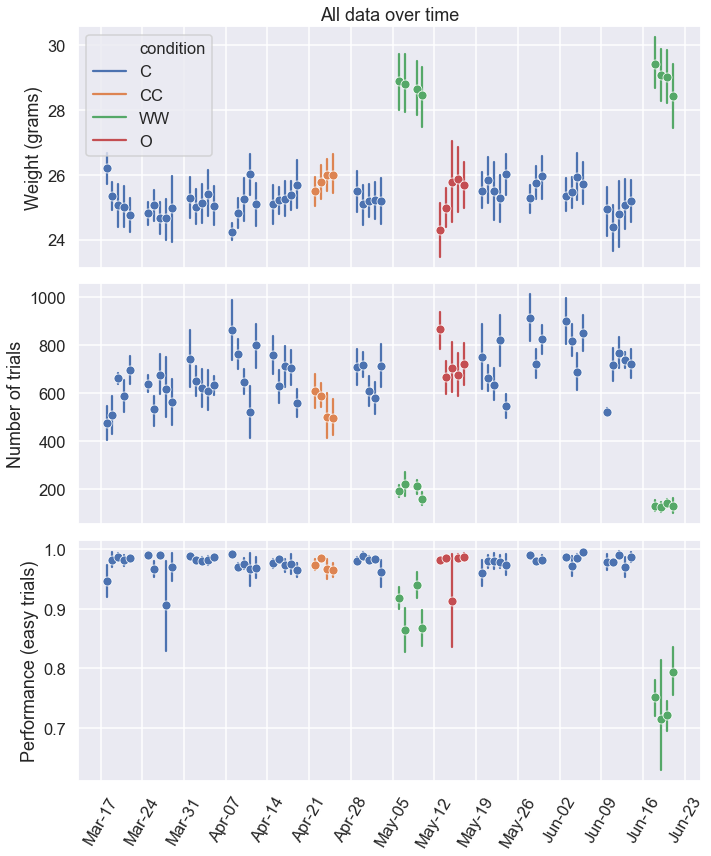

In [6]:
## NOW PLOT WITH SEABORN
f, ax = plt.subplots(3,1, sharex=True, figsize=(10, 12))
sns.lineplot(x="session_date", y="avg_weight", err_style='bars', ci=68, hue="condition", marker='o', 
             linewidth=0, data=df, ax=ax[0])
ax[0].set(ylabel="Weight (grams)", xlabel="Days")
sns.lineplot(x="session_date", y="n_trials", err_style='bars', ci=68, hue="condition", marker='o',  
             linewidth=0, data=df, ax=ax[1], legend=False)
ax[1].set(ylabel="Number of trials", xlabel="")
sns.lineplot(x="session_date", y="performance_easy", err_style='bars', ci=68, hue="condition", marker='o',  
             linewidth=0, data=df, ax=ax[2], legend=False)
ax[2].set(ylabel="Performance (easy trials)", xlabel="")

# set grid to show Mondays
fix_date_axis(ax[2])
ax[0].set_title('All data over time')
f.tight_layout()
f.savefig(os.path.join(figpath, "CA_over_time.pdf"))

Now that we have our data, let's visualize it!

The plot above shows an example of using seaborn (https://seaborn.pydata.org/index.html), see the documentation for many other types of plots you can make. 

Try to make this plot a bit nicer, by doing the following:
1. move the legend to the right of the plot, or make it smaller so it doesn't obscure the datapoints. you can also rotate the 'tickmarks' (dates) on the x-axis to make them more readable.
- make an additional column with the day of the week

2. play with the arguments to 'lineplot' - see e.g. what happens when linewidth=1, or ci=95
3. instead of marking each day by its water condition _that day_, change the dataframe to label it with the condition of _that week_ (so that e.g. a week with only 10% sucrose water, but _preceded_ by a 2% CA weekend is different from a week with 10% sucrose water, but _preceded by a regular water weekend). this should then indicate the color
4. check in Alyx that all mice on a given day have the same 'condition'. Also make sure there are data logged for each day, including the weekend.
4. repeat the plot for individual mice (hint: seaborn's FacetGrid)


Of these, 3 and 4 are the most important: the rest is 

Once this looks good, try to create a new plot that ignores the date, and plots all datapoints (weight and nr of trials) from one condition (weekend + week water regime) in one overview - as on the SfN poster. You can use e.g. seaborn's catplot to make it look nice.

Other todo (for Anne):
1. indicate Mondays 


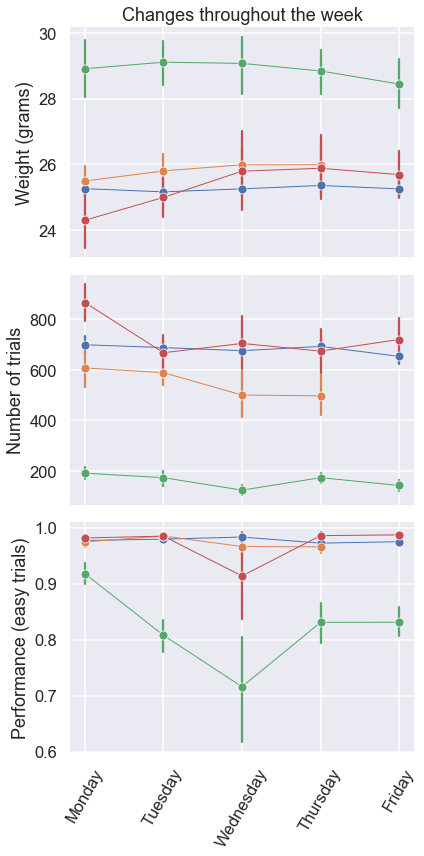

In [7]:
## NOW PLOT WITH SEABORN
f, ax = plt.subplots(3,1, sharex=True, figsize=(6, 12))
sns.lineplot(x="weekday", y="avg_weight", err_style='bars', ci=68, hue="condition", marker='o', 
             linewidth=1, data=df, ax=ax[0], legend=False)
ax[0].set(ylabel="Weight (grams)")
sns.lineplot(x="weekday", y="n_trials", err_style='bars', ci=68, hue="condition", marker='o',  
             linewidth=1, data=df, ax=ax[1], legend=False)
ax[1].set(ylabel="Number of trials")
sns.lineplot(x="weekday", y="performance_easy", err_style='bars', ci=68, hue="condition", marker='o',  
             linewidth=1, data=df, ax=ax[2], legend=False)
ax[2].set(ylabel="Performance (easy trials)", xticks=[0,1,2,3,4], 
          xticklabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], xlabel="")

for item in ax[2].get_xticklabels():
    item.set_rotation(60)
    
# set grid to show Mondays
ax[0].set_title('Changes throughout the week')
f.tight_layout()
f.savefig(os.path.join(figpath, "CA_within_week.pdf"))

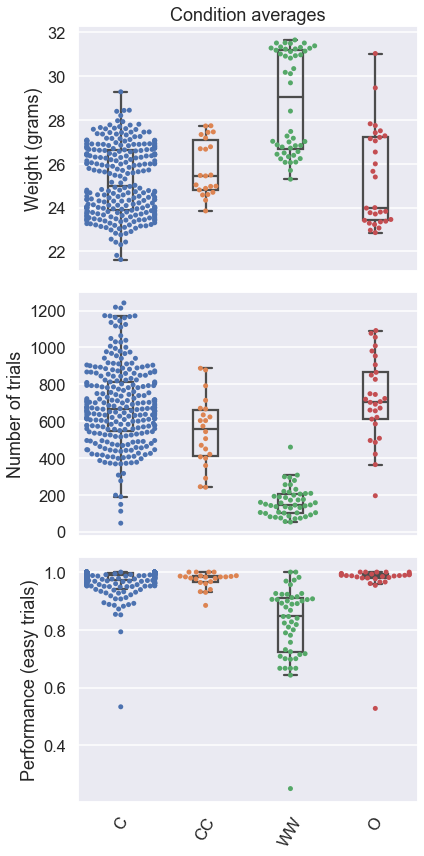

In [8]:
## NOW PLOT WITH SEABORN
f, ax = plt.subplots(3,1, sharex=True, figsize=(6, 12))

sns.swarmplot(x="condition", y="avg_weight", hue="condition", data=df, ax=ax[0])
sns.boxplot(x="condition", y="avg_weight", data=df, fliersize=0, ax=ax[0], boxprops={'facecolor':'None'}, width=.3)
ax[0].set(ylabel="Weight (grams)", xlabel="")
ax[0].get_legend().remove()

sns.swarmplot(x="condition", y="n_trials", hue="condition", data=df, ax=ax[1])
sns.boxplot(x="condition", y="n_trials", data=df, fliersize=0, ax=ax[1], boxprops={'facecolor':'None'}, width=.3)
ax[1].set(ylabel="Number of trials", xlabel="")
ax[1].get_legend().remove()

sns.swarmplot(x="condition", y="performance_easy", hue="condition", data=df, ax=ax[2])
sns.boxplot(x="condition", y="performance_easy", data=df, fliersize=0, ax=ax[2], boxprops={'facecolor':'None'}, width=.3)
ax[2].set(ylabel="Performance (easy trials)", xlabel="")
ax[2].get_legend().remove()

for item in ax[2].get_xticklabels():
    item.set_rotation(60)
    
# set grid to show Mondays
ax[0].set_title('Condition averages')
f.tight_layout()
f.savefig(os.path.join(figpath, "CA_stats.pdf"))

In [34]:
# NOW DO STATS ON THE TRIAL COUNTS
import statsmodels.api as sm
import statsmodels.formula.api as smf
md = smf.mixedlm("n_trials ~ condition", df, groups=df["subject_nickname"])
mdf = md.fit()
print(mdf.summary())

              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    n_trials  
No. Observations:     363        Method:                REML      
No. Groups:           6          Scale:                 31170.0826
Min. group size:      57         Likelihood:            -2382.3805
Max. group size:      62         Converged:             Yes       
Mean group size:      60.5                                        
------------------------------------------------------------------
                  Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------
Intercept         683.293   44.655  15.302 0.000  595.771  770.816
condition[T.CC]  -152.107   39.165  -3.884 0.000 -228.869  -75.346
condition[T.O]     33.381   34.476   0.968 0.333  -34.190  100.951
condition[T.WW]  -511.293   31.287 -16.342 0.000 -572.616 -449.971
Group Var       11286.127   42.560                                



In [35]:
md = smf.mixedlm("avg_weight ~ condition", df, groups=df["subject_nickname"])
mdf = md.fit()
print(mdf.summary())

          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: avg_weight
No. Observations:   363     Method:             REML      
No. Groups:         6       Scale:              0.6501    
Min. group size:    57      Likelihood:         -453.7221 
Max. group size:    62      Converged:          Yes       
Mean group size:    60.5                                  
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept       25.224    0.667 37.808 0.000 23.917 26.532
condition[T.CC]  0.766    0.179  4.285 0.000  0.416  1.117
condition[T.O]   0.197    0.157  1.254 0.210 -0.111  0.506
condition[T.WW]  3.663    0.143 25.632 0.000  3.382  3.943
Group Var        2.657    2.106                           

